## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Notebook config

In [2]:
#Cities are dam names ('presa_laboca', 'presa_cerroprieto', 'presa_elcuchillo')
city_list = ['presa_laboca','presa_cerroprieto','presa_elcuchillo']

# Analysis name
index_analysis = 'ndwi'

# Analysed raster data from local directory:
tmp_dir = f'../../../data/processed/tmp_{index_analysis}/'

export_csv_forcorrelation = True

save_plots = True

## Data download

### Data download - Dams

Dams polygon (Drawn using Google Earth)

<Axes: >

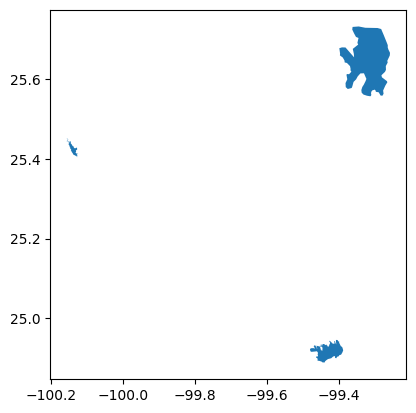

In [3]:
laboca = gpd.read_file("../../../data/external/temporal_todocker/presa_laboca.gpkg")
cerroprieto = gpd.read_file("../../../data/external/temporal_todocker/presa_cerroprieto.gpkg")
elcuchillo = gpd.read_file("../../../data/external/temporal_todocker/presa_elcuchillo.gpkg")

# Create areas of interest
gdfs = [laboca,cerroprieto,elcuchillo]
poly = pd.concat(gdfs)

poly.reset_index(inplace=True)
columns_tokeep = ['Name','geometry']
poly = poly[columns_tokeep]

poly.plot()

### Data download - Raster Analysis Data

Download data

In [4]:
#IF THERE EVER ARE MORE ANALYSED CITIES IN NDWI DATABASE

# Info to query
#raster_schema = 'raster_analysis'
#raster_folder = '{}_analysis_hex'.format(index_analysis)

#raster_dataset = gpd.GeoDataFrame()

#for city in city_list:
#    query = f"SELECT * FROM {raster_schema}.{raster_folder} WHERE \"city\" LIKE \'{city}%%\'"
#    temp_dataset = aup.df_from_query(query)
#    raster_dataset = pd.concat([raster_dataset, temp_dataset],ignore_index = True, axis = 0)

#print(raster_dataset.shape)
#raster_dataset.head(2)

In [5]:
# Info to query
raster_schema = 'raster_analysis'
raster_folder = '{}_analysis_hex'.format(index_analysis)

query = f"SELECT * FROM {raster_schema}.{raster_folder}"
ndwi_hex = aup.gdf_from_query(query,geometry_col='geometry')

print(ndwi_hex.shape)
ndwi_hex.head(2)

(251794, 11)


,hex_id,res,ndwi_mean,ndwi_std,ndwi_median,ndwi_max,ndwi_min,ndwi_diff,ndwi_tend,city,geometry
0,8c48a2c4841d7ff,12,-0.643779,0.138022,-0.692456,-0.555807,-0.739539,0.183731,0.002027,presa_laboca,"POLYGON ((-100.12212 25.40985, -100.12203 25.4..."
1,8c48a2c4bae0dff,12,-0.595470,0.129333,-0.635417,-0.476425,-0.675642,0.199217,0.001727,presa_laboca,"POLYGON ((-100.13914 25.43324, -100.13904 25.4..."


### Data download - Clip Raster Analysis Data

Using centroids, locate hex within cities (dams)

<Axes: >

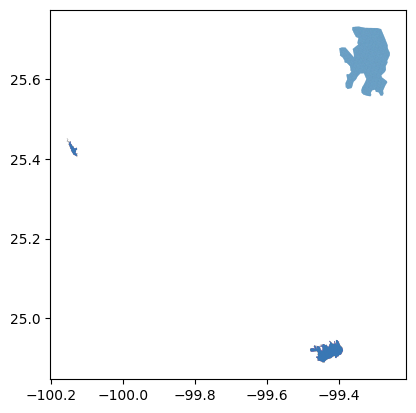

In [6]:
# Find hex centroids
gdf = ndwi_hex.to_crs("EPSG:6372")
centroids = gdf.centroid
centroids = centroids.to_crs("EPSG:4326")

# Turn them into gdf
centroids_gdf = gpd.GeoDataFrame(centroids)
centroids_gdf = centroids_gdf.rename(columns={0:'geometry'})

# Intersect centroids with original analysed_raster to keep hex_id in centroids
centroids_hexid = gpd.overlay(centroids_gdf,ndwi_hex,keep_geom_type=True)
columns_tokeep = ['hex_id','geometry']
centroids_hexid = centroids_hexid[columns_tokeep]

# Intersect spatially centroids with dam
centroids_hexid_dam = gpd.overlay(centroids_hexid,poly,keep_geom_type=True)

# Select hexagons from centroids's hex_id
centroids_hexid_dam_f = centroids_hexid_dam['hex_id']
ndwi_hex_dams = pd.merge(centroids_hexid_dam_f,ndwi_hex, on='hex_id')
ndwi_hex_dams = ndwi_hex_dams.set_geometry('geometry')

ndwi_hex_dams.plot()

### Data download - Complete dataset

Opción A: Descargar de la DB filtrando por hex_id (+2000 segs y lo detuve)

In [7]:
# Finds hex_id codes from hex_grid
#hex_ids = str(tuple(list(ndwi_hex_dams["hex_id"].unique())))

# Info to query
#raster_schema = 'raster_analysis'
#raster_folder = '{}_complete_dataset_hex'.format(index_analysis)

#query = f"SELECT * FROM {raster_schema}.{raster_folder} WHERE \"hex_id\" IN {hex_ids}"
#raster_dataset = aup.df_from_query(query)

#print(raster_dataset.shape)
#raster_dataset.head(2)

Opción B: Descargar de la DB sin filtrar y después filtrar por hex_id (+800 segs, luego crash)

In [8]:
#OPCIÓN B: DESCARGAR DE LA DB Y DESPUÉS FILTRAR POR hex_id (+800 segs, luego crasheó)

#Download data
#raster_schema = 'raster_analysis'
#raster_folder = '{}_complete_dataset_hex'.format(index_analysis)

#query = f"SELECT * FROM {raster_schema}.{raster_folder}"
#raster_dataset = aup.df_from_query(query)

#Filter, hex_ids within dams only
#hex_idlist = list(ndwi_hex_dams["hex_id"].unique())
#raster_dataset['within_dam'] = raster_dataset['hex_id'].apply(lambda x: 1 if x in hex_idlist else 0)
#dam_complete_dataset = raster_dataset.loc[raster_dataset['within_dam'] == 1]

#Show
#print(raster_dataset.shape)
#raster_dataset.head(2)

In [9]:
#Filter, hex_ids within dams only (+29000 segs, luego me rendí)
#hex_idlist = list(ndwi_hex_dams["hex_id"].unique())
#complete_dataset['within_dam'] = complete_dataset['hex_id'].apply(lambda x: 1 if x in hex_idlist else 0)
#raster_dataset = complete_dataset.loc[raster_dataset['within_dam'] == 1]

OPCIÓN C - Parte 1: Cargar desde visual studio code y unir (Aprox. 50 segs)

In [10]:
#Load data
city = 'presa_laboca'
r = 12
laboca_complete_dataset = pd.read_csv(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v0.csv')

city = 'presa_cerroprieto'
r = 12
cerroprieto_complete_dataset = pd.read_csv(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v0.csv')

city = 'presa_elcuchillo'
r = 11
elcuchillo_complete_dataset = pd.read_csv(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v0.csv')

#Show
print(laboca_complete_dataset.shape)
print(cerroprieto_complete_dataset.shape)
print(elcuchillo_complete_dataset.shape)

#------------------------------------------------------------------------------------------------------------

#Gdfs to concatenate
complete_gdfs = [laboca_complete_dataset,cerroprieto_complete_dataset,elcuchillo_complete_dataset]

#Concatenate
complete_dataset = pd.concat(complete_gdfs)

#Show
print(complete_dataset.shape)

#------------------------------------------------------------------------------------------------------------

complete_dataset = complete_dataset.drop(columns=['Unnamed: 0'])
complete_dataset.head(2)

(3343740, 7)
(12153016, 7)
(7668292, 7)
(23165048, 7)


,hex_id,res,ndwi,month,year,city
0,8c48a2c4841d7ff,12,-0.755518,1,2016,presa_laboca
1,8c48a2c4bae0dff,12,-0.597222,1,2016,presa_laboca


OPCIÓN C - PARTE 2: Filtrar con un inner merge (Conserva los hexs que están tanto en ndwi_hex_dams como en complete_dataset_dams).

In [11]:
gdf1 = ndwi_hex_dams.copy()[['hex_id','res','city','geometry']]
df2 = complete_dataset.copy()[['hex_id','ndwi','month', 'year']]

complete_dataset_dams = pd.merge(gdf1, df2, how='inner', on='hex_id')

#Show
print(complete_dataset_dams.shape)
complete_dataset_dams.head(2)

(15050924, 7)


,hex_id,res,city,geometry,ndwi,month,year
0,8c48a2c4b8ac1ff,12,presa_laboca,"POLYGON ((-100.13153 25.42445, -100.13143 25.4...",0.954590,1,2016
1,8c48a2c4b8ac1ff,12,presa_laboca,"POLYGON ((-100.13153 25.42445, -100.13143 25.4...",0.994324,2,2016


## Data treatment

### Data treatment - Create datetime data

In [ ]:
#Creates datetime data by adding month (string) + / + year (string)
complete_dataset_dams['date'] = pd.to_datetime(complete_dataset_dams['month'].astype(str) + '/' + complete_dataset_dams['year'].astype(str))

#Strips the day, leaving month and year
complete_dataset_dams['date'] = complete_dataset_dams['date'].apply(lambda x: x.strftime('%Y-%m'))

#Show
print(complete_dataset_dams.shape)
complete_dataset_dams.head(2)

### Data treatment - Create raster categories

In [ ]:
# Creating vegetation categories
complete_dataset_dams['ndwi_category'] = np.nan

complete_dataset_dams.loc[complete_dataset_dams.ndwi>=0.2 , 'ndwi_category'] = 'Water surface'        
complete_dataset_dams.loc[(complete_dataset_dams.ndwi>=0.0)&
             (complete_dataset_dams.ndwi<0.2), 'ndwi_category'] = 'Flooding, humidity'
complete_dataset_dams.loc[(complete_dataset_dams.ndwi>=-0.3)&
             (complete_dataset_dams.ndwi<0.0), 'ndwi_category'] = 'Moderate drought, non-aqueous surfaces'
complete_dataset_dams.loc[(complete_dataset_dams.ndwi<-0.3), 'ndwi_category'] = 'Drought, non-aqueous surfaces'

# Ordering data
categories = ['Drought, non-aqueous surfaces', 'Moderate drought, non-aqueous surfaces', 'Flooding, humidity', 'Water surface']
complete_dataset_dams['ndwi_category'] = pd.Categorical(complete_dataset_dams['ndwi_category'], categories=categories, ordered=True)

#Show
print(complete_dataset_dams.shape)
complete_dataset_dams.head(2)

## Data analysis

### Data analysis - Summarize data by date in new dataframe

In [ ]:
#Calculate average hex area according to resolution and location
available_dates = len(complete_dataset_dams.date.unique())
print(available_dates)

#Empty historical behaviour dataset
historical_behaviour = pd.DataFrame()

#Summarize data
#Loop for each city (dam)
for city in complete_dataset_dams.city.unique():
    
    #Create empty temporary dataFrame
    cols = ['date', 'ndwi_category', 'hexcount']
    historical_temp = pd.DataFrame(columns=cols, index=range(available_dates*4)) # rows = available dates * available categories
    historical_temp['city'] = city 

    #Loop for each row (date)
    count = 0
    
    #PRIMERA SUBDIVISIÓN: DATASET DE LA CIUDAD.
    complete_bycity = complete_dataset_dams.loc[(complete_dataset_dams.city == city)]

    #Loop for each date in city
    for date in complete_bycity.date.unique():
        #SEGUNDA SUBDIVISIÓN: DATASET DE LA CIUDAD Y LA FECHA.
        complete_bydate = complete_bycity.loc[(complete_bycity.date == date)]

        #Loop for each raster category in the date in the city (dam)
        for cat in categories:
            #TERCERA SUBDIVISIÓN: DATASET DE LA CIUDAD, LA FECHA Y LA CATEGORÍA.
            complete_bydate_cat = complete_bydate.loc[(complete_bydate.ndwi_category == cat)]
            
            hexcount = complete_bydate_cat.shape[0]

            #Register data in DataFrame
            historical_temp.loc[count].date = date
            historical_temp.loc[count].ndwi_category = cat
            historical_temp.loc[count].hexcount = hexcount

            #Next row (date) in city (dam) dataFrame
            count = count + 1
    
    #When all dates of city are over, concat and re-start count and data for following city (dam)
    historical_behaviour = pd.concat([historical_behaviour,historical_temp])

#Save month data
historical_behaviour['month'] = historical_behaviour['date'].apply(lambda x: pd.Timestamp(x).month)

### Export data for correlation with Andres's data (Notebook 03_cruce_ndwi_nivelespresas.ipynb)

In [42]:
if export_csv_forcorrelation:
    complete_bydate = pd.DataFrame()  

    for city in complete_dataset_dams.city.unique():

        presa_gdf = complete_dataset_dams.loc[(complete_dataset_dams.city == city)]

        #presa_gdf['almacenaactual'] = presa_gdf['almacenaactual'].astype('float')

        summary = presa_gdf.groupby('date').agg({'ndwi':np.mean})
        summary['city'] = city
        summary = summary.reset_index()

        complete_bydate = pd.concat([complete_bydate,summary])

    complete_bydate = complete_bydate.rename(columns={'ndwi':'ndwi_mean'})

    #Show
    print(complete_bydate.head(2))

      date  ndwi_mean          city
0  2016-01   0.579427  presa_laboca
1  2016-02   0.828112  presa_laboca


In [44]:
complete_bydate_laboca = complete_bydate.loc[complete_bydate.city=='presa_laboca']
complete_bydate_laboca.tail(8)         

,date,ndwi_mean,city
84,2023-01,0.087028,presa_laboca
85,2023-02,0.121533,presa_laboca
86,2023-03,0.051959,presa_laboca
87,2023-04,0.028669,presa_laboca
88,2023-05,0.005378,presa_laboca
89,2023-06,-0.017912,presa_laboca
90,2023-07,-0.047156,presa_laboca
91,2023-08,-0.057435,presa_laboca


In [16]:
#Export to csv
if export_csv_forcorrelation:
    #Copy
    csv_raster_dataset = complete_bydate.copy()
    
    #Download dataframe
    csv_raster_dataset.to_csv("../../../data/external/temporal_fromjupyter/nldams_ndwi.csv")

### Data analysis - Seasonal (by month) behaviour

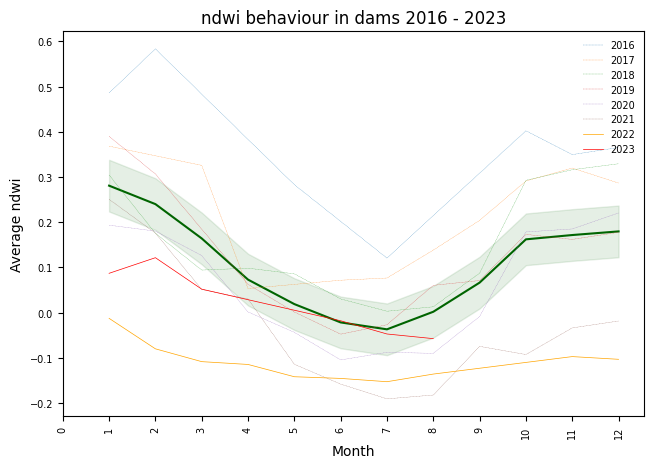

In [47]:
columns_tokeep = ['date','month','percentage']

# ---------- Plotting whole data by month (main line) ----------
# DATA
complete_bymonth = complete_dataset_dams.groupby('month').agg({'month':np.mean,'ndwi':np.mean})

# ------- DATA AND CONFIDENCE INTERVAL PLOT -------
#Confidence interval data
x = complete_bymonth.month
y = complete_bymonth.ndwi
ci = 1.96 * np.std(y)/np.sqrt(len(x))

#Plot
fig, ax = plt.subplots(figsize=(7.5,5))
ax.plot(x,y, color = 'darkgreen')
ax.fill_between(x, (y-ci), (y+ci), color='darkgreen', alpha=.1)

# ---------- MONTHLY DATA (dotted lines) ----------

# Find all data years
available_years = list(complete_dataset_dams['year'].unique())

#Iterate over each year
for current_year in available_years:
    #Isolating df
    year_dataset_dams = complete_dataset_dams.loc[(complete_dataset_dams.year == current_year)]
    #Grouping by month    
    data_bymonth = year_dataset_dams.groupby('month').agg({'ndwi':np.mean})
    #Plotting
    if current_year == 2022:
        plt.plot(data_bymonth, linewidth = 0.5, label=current_year,c='orange');
    elif current_year == 2023:
        plt.plot(data_bymonth, linewidth = 0.5, label=current_year,c='red'); 
    else:
        plt.plot(data_bymonth, '--', linewidth = 0.20, label=current_year);
    
    
# ---------- FORMAT ----------
# Format - Titles
plt.title('ndwi behaviour in dams 2016 - 2023')
plt.xlabel('Month')
plt.ylabel('Average ndwi')

# Format - x ticks
# Tag all 12 months
plt.xticks(np.arange(0, 13))
# Rotate ticks
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_size(7)

# Format - y ticks
y = plt.gca().yaxis
for item in y.get_ticklabels():
    item.set_size(7)

# Format - Legend
plt.legend(frameon=False,
           loc=1, 
           fontsize = 7)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndwi/ndwi_behaviour_dams_lineplot.svg")

### Data analysis - Historical behaviour

Calculate basics for analysis

In [20]:
#Calculate average hex area according to resolution and location (Not currently in use)
#gdf = ndwi_hex_dams.to_crs("EPSG:6372")
#gdf['area'] = gdf.area
#average_hexarea = gdf.area.mean()
#print(average_hexarea)

#Calculate average hex area according to resolution and location
available_dates = len(complete_dataset_dams.date.unique())
print(available_dates)

92


Calculate historical behaviour

In [21]:
historical_behaviour = pd.DataFrame()

for city in complete_dataset_dams.city.unique():
    
    #Create empty temporary dataFrame
    cols = ['date', 'ndwi_category', 'hexcount','percentage']
    historical_temp = pd.DataFrame(columns=cols, index=range(available_dates*4)) # rows = available dates * available categories
    historical_temp['city'] = city 

    #Loop for each date
    count = 0
    
    #PRIMERA SUBDIVISIÓN: DATASET DE LA CIUDAD.
    complete_bycity = complete_dataset_dams.loc[(complete_dataset_dams.city == city)]

    for date in complete_bycity.date.unique():
        #SEGUNDA SUBDIVISIÓN: DATASET DE LA CIUDAD Y LA FECHA.
        complete_bydate = complete_bycity.loc[(complete_bycity.date == date)]
        total_citydate_hex = complete_bydate.shape[0]

        #Loop for each raster category
        for cat in categories:
            #TERCERA SUBDIVISIÓN: DATASET DE LA CIUDAD, LA FECHA Y LA CATEGORÍA.
            complete_bydate_cat = complete_bydate.loc[(complete_bydate.ndwi_category == cat)]
            hexcount = complete_bydate_cat.shape[0]

            #Register data in DataFrame
            historical_temp.loc[count].date = date
            historical_temp.loc[count].ndwi_category = cat
            historical_temp.loc[count].hexcount = hexcount
            historical_temp.loc[count].percentage = (hexcount/total_citydate_hex)*100     

            #Next row in DataFrame
            count = count + 1
    
    #When all dates of city are over, concat and re-start count and data for following city
    historical_behaviour = pd.concat([historical_behaviour,historical_temp])

#Save month data
historical_behaviour['month'] = historical_behaviour['date'].apply(lambda x: pd.Timestamp(x).month)

#Show
print(historical_behaviour.shape)
historical_behaviour

(1104, 6)


,date,ndwi_category,hexcount,percentage,city,month
0,2016-01,"Drought, non-aqueous surfaces",520,4.337671,presa_laboca,1.0
1,2016-01,"Moderate drought, non-aqueous surfaces",489,4.079079,presa_laboca,1.0
2,2016-01,"Flooding, humidity",334,2.786119,presa_laboca,1.0
3,2016-01,Water surface,10645,88.79713,presa_laboca,1.0
4,2016-02,"Drought, non-aqueous surfaces",410,3.420087,presa_laboca,2.0
...,...,...,...,...,...,...
363,NaN,NaN,NaN,NaN,presa_elcuchillo,NaN
364,NaN,NaN,NaN,NaN,presa_elcuchillo,NaN
365,NaN,NaN,NaN,NaN,presa_elcuchillo,NaN
366,NaN,NaN,NaN,NaN,presa_elcuchillo,NaN


In [27]:
#En lo que corro el resto de las presas para 2023:
historical_behaviour = historical_behaviour.dropna()
historical_behaviour

,date,ndwi_category,hexcount,percentage,city,month
0,2016-01,"Drought, non-aqueous surfaces",520,4.337671,presa_laboca,1.0
1,2016-01,"Moderate drought, non-aqueous surfaces",489,4.079079,presa_laboca,1.0
2,2016-01,"Flooding, humidity",334,2.786119,presa_laboca,1.0
3,2016-01,Water surface,10645,88.79713,presa_laboca,1.0
4,2016-02,"Drought, non-aqueous surfaces",410,3.420087,presa_laboca,2.0
...,...,...,...,...,...,...
331,2022-11,Water surface,31182,46.262722,presa_elcuchillo,11.0
332,2022-12,"Drought, non-aqueous surfaces",9866,14.637548,presa_elcuchillo,12.0
333,2022-12,"Moderate drought, non-aqueous surfaces",26119,38.751076,presa_elcuchillo,12.0
334,2022-12,"Flooding, humidity",2633,3.906412,presa_elcuchillo,12.0


In [36]:
laboca_behaviour = historical_behaviour.loc[(historical_behaviour.city == 'presa_laboca')]
water_laboca = laboca_behaviour.loc[(laboca_behaviour.ndwi_category == 'Water surface')]
water_laboca.tail(8)

,date,ndwi_category,hexcount,percentage,city,month
339,2023-01,Water surface,470,3.920587,presa_laboca,1.0
343,2023-02,Water surface,4480,37.370704,presa_laboca,2.0
347,2023-03,Water surface,13,0.108442,presa_laboca,3.0
351,2023-04,Water surface,0,0.0,presa_laboca,4.0
355,2023-05,Water surface,0,0.0,presa_laboca,5.0
359,2023-06,Water surface,6,0.05005,presa_laboca,6.0
363,2023-07,Water surface,0,0.0,presa_laboca,7.0
367,2023-08,Water surface,0,0.0,presa_laboca,8.0


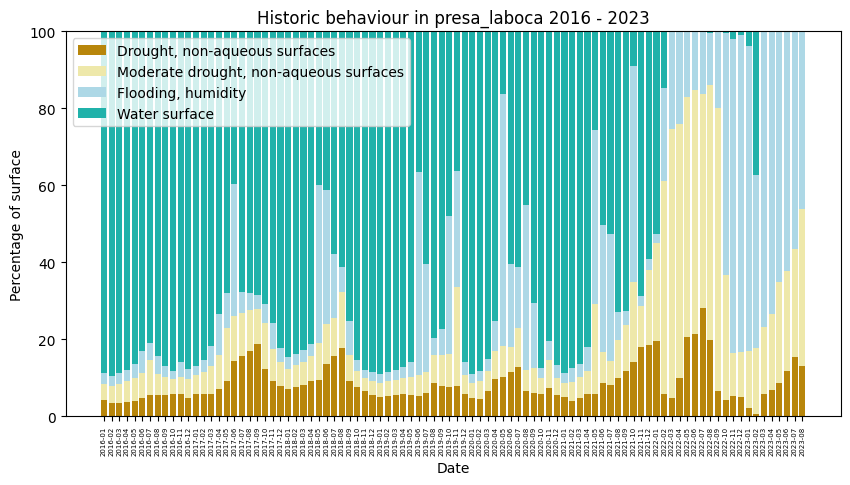

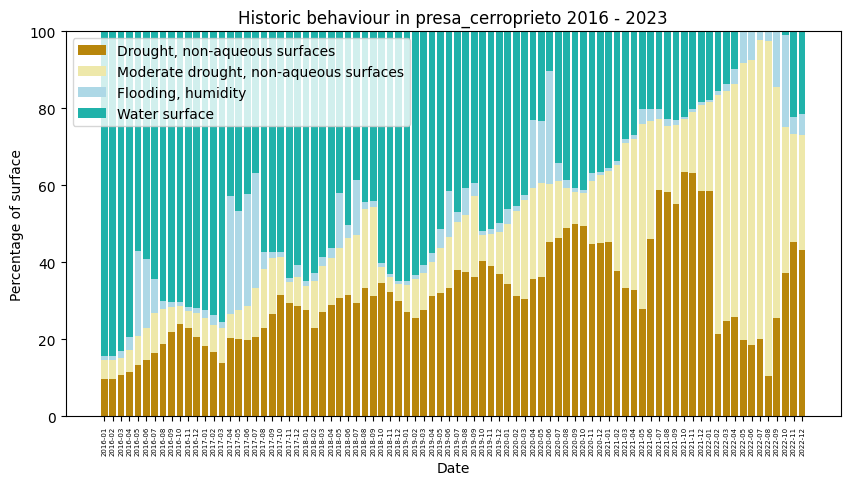

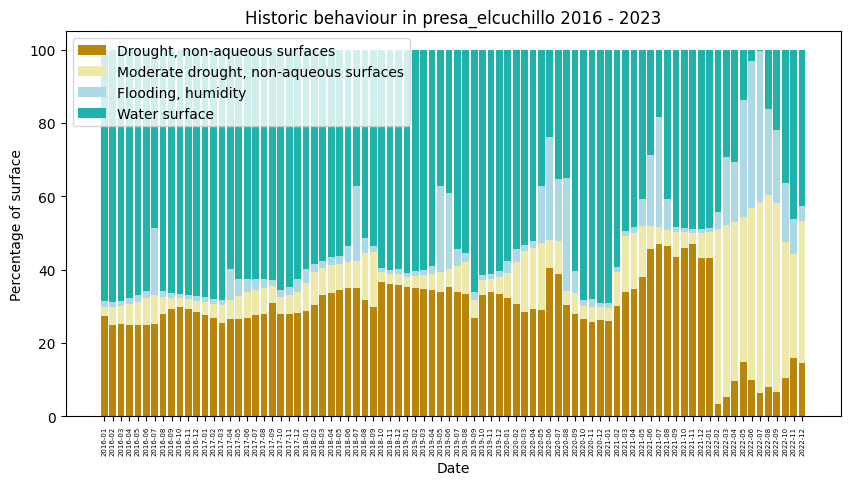

In [50]:
#Iterate over each city
for city in historical_behaviour.city.unique():
    
    #--------------- Isolate data for dam and clean data ---------------
    historicalbehaviour_dam = historical_behaviour.loc[(historical_behaviour.city == city)]
    
    #--------------- Create series of data ---------------
    columns_tokeep = ['date','hexcount']
    
    water = historicalbehaviour_dam.loc[(historicalbehaviour_dam.ndwi_category == 'Water surface')]
    water = water.reset_index()
    water = water[columns_tokeep]

    flood = historicalbehaviour_dam.loc[(historicalbehaviour_dam.ndwi_category == 'Flooding, humidity')]
    flood = flood.reset_index()
    flood = flood[columns_tokeep]

    moderate = historicalbehaviour_dam.loc[(historicalbehaviour_dam.ndwi_category == 'Moderate drought, non-aqueous surfaces')]
    moderate = moderate.reset_index()
    moderate = moderate[columns_tokeep]

    drought = historicalbehaviour_dam.loc[(historicalbehaviour_dam.ndwi_category == 'Drought, non-aqueous surfaces')]
    drought = drought.reset_index()
    drought = drought[columns_tokeep] 
    
    #--------------- Plot data ---------------
    x = water['date']
    y4 = (water['hexcount'] / (water['hexcount']+flood['hexcount']+moderate['hexcount']+drought['hexcount']))*100
    y3 = (flood['hexcount'] / (water['hexcount']+flood['hexcount']+moderate['hexcount']+drought['hexcount']))*100
    y2 = (moderate['hexcount'] / (water['hexcount']+flood['hexcount']+moderate['hexcount']+drought['hexcount']))*100
    y1 = (drought['hexcount'] / (water['hexcount']+flood['hexcount']+moderate['hexcount']+drought['hexcount']))*100

    plt.figure(figsize=(10,5))
    plt.bar(x, y1, color='darkgoldenrod',label='Drought, non-aqueous surfaces')
    plt.bar(x, y2, bottom=y1, color='palegoldenrod',label='Moderate drought, non-aqueous surfaces')
    plt.bar(x, y3, bottom=y1+y2, color='lightblue',label='Flooding, humidity')
    plt.bar(x, y4, bottom=y1+y2+y3, color='lightseagreen',label='Water surface')

    
    # ---------- Format ----------
    # Format - Titles
    plt.title('Historic behaviour in {} 2016 - 2023'.format(city))
    plt.xlabel('Date')
    plt.ylabel('Percentage of surface')
    
    # Format - x ticks
    # Rotate ticks
    x = plt.gca().xaxis
    for item in x.get_ticklabels():
        item.set_rotation(90)
        item.set_size(5)
        
    # Format - Legend
    plt.legend(frameon=False,
               loc='upper left',
               fontsize = 5)
    
    legend = plt.legend(frameon = 1)
    legend.fontsize = 5
    frame = legend.get_frame()
    frame.set_facecolor('white')
    
    # ---------- Save Plot ----------
    if save_plots:
        plt.savefig("../../../output/figures/ndwi/historic_barplot_{}.svg".format(city))

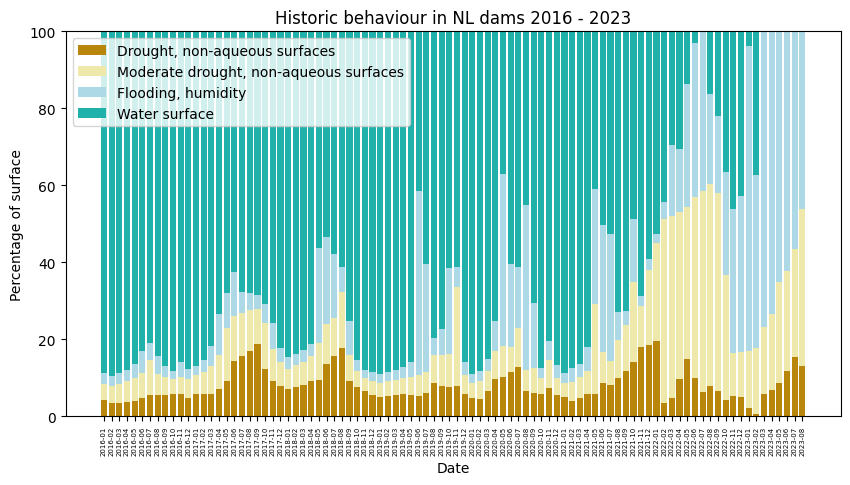

In [52]:
#--------------- Copy data of all dams ---------------
historicalbehaviour_dam = historical_behaviour.copy()

#--------------- Create series of data ---------------
columns_tokeep = ['date','hexcount']

water = historicalbehaviour_dam.loc[(historicalbehaviour_dam.ndwi_category == 'Water surface')]
water = water.reset_index()
water = water[columns_tokeep]

flood = historicalbehaviour_dam.loc[(historicalbehaviour_dam.ndwi_category == 'Flooding, humidity')]
flood = flood.reset_index()
flood = flood[columns_tokeep]

moderate = historicalbehaviour_dam.loc[(historicalbehaviour_dam.ndwi_category == 'Moderate drought, non-aqueous surfaces')]
moderate = moderate.reset_index()
moderate = moderate[columns_tokeep]

drought = historicalbehaviour_dam.loc[(historicalbehaviour_dam.ndwi_category == 'Drought, non-aqueous surfaces')]
drought = drought.reset_index()
drought = drought[columns_tokeep]

#--------------- Plot data ---------------
x = water['date']
y4 = (water['hexcount'] / (water['hexcount']+flood['hexcount']+moderate['hexcount']+drought['hexcount']))*100
y3 = (flood['hexcount'] / (water['hexcount']+flood['hexcount']+moderate['hexcount']+drought['hexcount']))*100
y2 = (moderate['hexcount'] / (water['hexcount']+flood['hexcount']+moderate['hexcount']+drought['hexcount']))*100
y1 = (drought['hexcount'] / (water['hexcount']+flood['hexcount']+moderate['hexcount']+drought['hexcount']))*100

plt.figure(figsize=(10,5))
plt.bar(x, y1, color='darkgoldenrod',label='Drought, non-aqueous surfaces')
plt.bar(x, y2, bottom=y1, color='palegoldenrod',label='Moderate drought, non-aqueous surfaces')
plt.bar(x, y3, bottom=y1+y2, color='lightblue',label='Flooding, humidity')
plt.bar(x, y4, bottom=y1+y2+y3, color='lightseagreen',label='Water surface')


# ---------- Format ----------
# Format - Titles
plt.title('Historic behaviour in NL dams 2016 - 2023')
plt.xlabel('Date')
plt.ylabel('Percentage of surface')

# Format - x ticks
# Rotate ticks
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_size(5)

# Format - Legend
plt.legend(frameon=False,
           loc='upper left',
           fontsize = 5)

legend = plt.legend(frameon = 1)
legend.fontsize = 5
frame = legend.get_frame()
frame.set_facecolor('white')

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndwi/ndwi_historic_barplot_nl.svg")

In [20]:
#¿TRANSPOSICIÓN PARA MAPAS?

#raster_dataset = complete_dataset.drop_duplicates(subset='hex_id', keep="last")[['hex_id','res','city']].copy()

#for date in list(complete_dataset.date.unique()):
#    date_dataset = complete_dataset.loc[complete_dataset.date == date,['hex_id','ndwi']]
#    date_dataset = date_dataset.rename(columns={'ndwi':date})
#    raster_dataset = raster_dataset.merge(date_dataset, on='hex_id')
    
#print(raster_dataset.shape)
#raster_dataset.head(2)

#city = 'presas'
#r = 'n'
#raster_dataset.to_csv(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_.csv')